https://www.youtube.com/watch?v=aircAruvnKk
https://www.youtube.com/watch?v=IHZwWFHWa-w

In [ ]:
%matplotlib inline 
import pickle
import torch
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

from IPython.display import Image, display
from matplotlib.pyplot import imshow


## Load Data

In [51]:
# Load data from www.openml.org
mnist_path = r'D:/workspace/machine-learning/number-recognition/local_data/mnist.pickle'
with open(mnist_path, 'rb') as f:
    first = pickle.load(f)
    second = pickle.load(f)
# Heuristics: prefer 2D array as X (samples, features) and 1D as y (labels)
if hasattr(first, 'shape') and hasattr(second, 'shape'):
    try:
        if getattr(first, 'ndim', None) == 2 and getattr(second, 'ndim', None) == 1:
            X, y = first, second
        elif getattr(second, 'ndim', None) == 2 and getattr(first, 'ndim', None) == 1:
            X, y = second, first
        else:
            X, y = first, second
    except Exception:
        X, y = first, second
else:
    X, y = first, second
print(f"Dataset shapes: X={X.shape}, y={y.shape}")

Dataset shapes: X=(70000, 784), y=(70000,)


In [52]:
# Determine device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Recognition Module

In [53]:
class NumberRecognition(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_head = torch.nn.Sequential(
            torch.nn.Linear(784, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 10),
            torch.nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.fc_head(x)

In [54]:
recognition_model = NumberRecognition().to(device)
recognition_model

NumberRecognition(
  (fc_head): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)

# Split the data (stratify preserves label proportions)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Ensure labels are integers
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Convert to torch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_t = torch.tensor(y_train, dtype=torch.long, device=device)

X_test_t = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_t = torch.tensor(y_test, dtype=torch.long, device=device)

# Create datasets and loaders
train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Now `train_dataset`, `test_dataset`, `train_loader`, and `test_loader` are available

## Explore the dataset

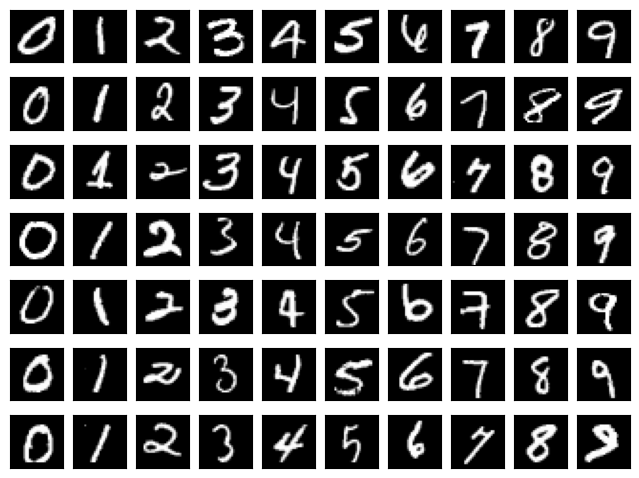

In [56]:
%matplotlib inline 
fig = plt.figure(figsize=(8,6))
for i in range(10):
    train_set_index = np.nonzero(y_train==i)[0]
    for j in range(7):
        ax = plt.subplot(7,10,i+j*10+1)        
        ax.imshow(np.reshape(X_train[train_set_index[j]],(28,28)),cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()

In [67]:
# demonstration purposes
x, y = next(iter(train_loader))
y_pred = recognition_model(x)
print(y_pred.argmax(dim=1))
print(x)

tensor([1, 0, 1, 8, 7, 7, 9, 6, 6, 3, 2, 6, 0, 8, 0, 7, 5, 9, 4, 5, 3, 9, 4, 6,
        7, 5, 5, 3, 3, 7, 4, 2, 8, 2, 6, 3, 1, 6, 1, 6, 4, 1, 3, 0, 3, 1, 5, 1,
        6, 8, 7, 8, 2, 5, 1, 8, 0, 7, 6, 0, 3, 6, 4, 0], device='cuda:0')
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')


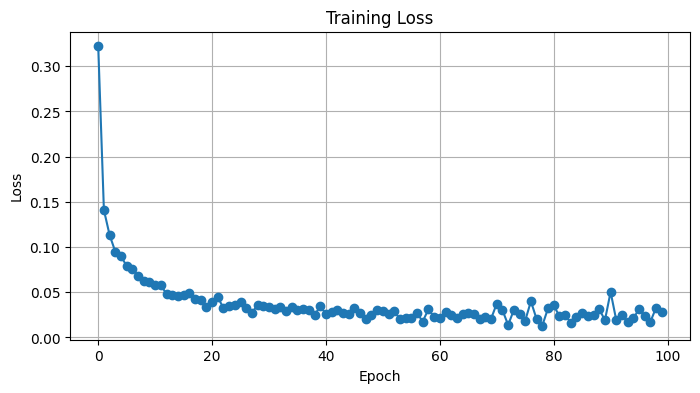

In [59]:
# Plot training loss
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(epoch_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

In [60]:
# model accuracy evaluation
recognition_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = recognition_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 97.59%


In [61]:
# model accuracy evaluation
recognition_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in train_loader:
        outputs = recognition_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = correct / total
print(f"Train Accuracy: {accuracy * 100:.2f}%")

Train Accuracy: 99.75%


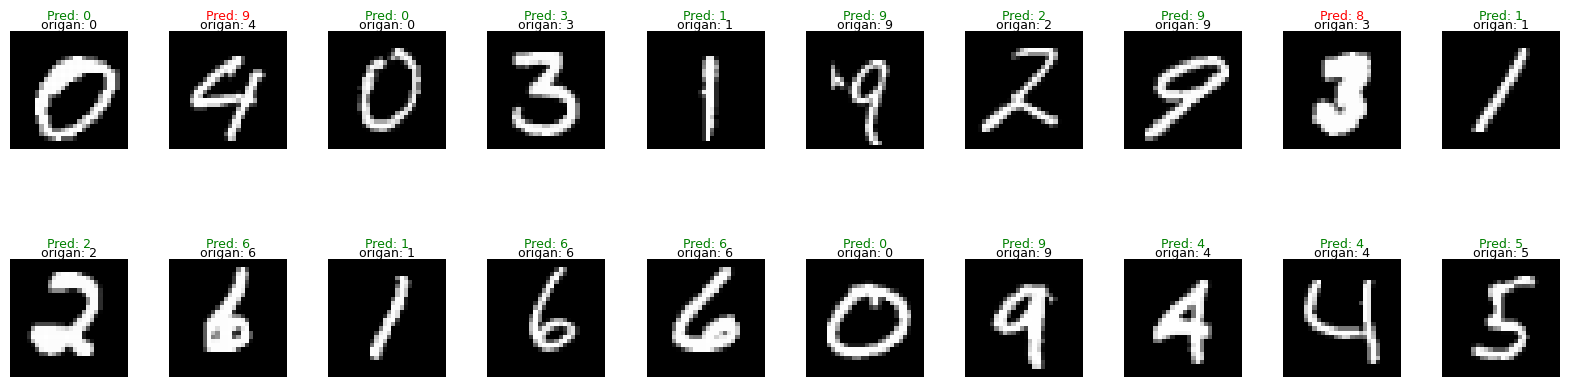

In [73]:
# Run predictions for N random test images and display results (max 10 per row)
import numpy as np
import math
import matplotlib.pyplot as plt
import torch

display_quantity = 20  # change this number as desired
display_quantity = int(display_quantity)
recognition_model.eval()
inds = np.random.choice(len(X_test), display_quantity, replace=False)
cols = min(10, display_quantity)
rows = math.ceil(display_quantity / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2.5))
# flatten axes for easy indexing (handle case rows==1 or cols==1)
if isinstance(axes, np.ndarray):
    axes_flat = axes.flatten()
else:
    axes_flat = [axes]

for i, idx in enumerate(inds):
    ax = axes_flat[i]
    img = X_test[idx].reshape(28,28)
    inp = torch.tensor(X_test[idx], dtype=torch.float32, device=device).unsqueeze(0)
    with torch.no_grad():
        out = recognition_model(inp)
        probs = torch.exp(out)
        pred = int(probs.argmax(dim=1).item())
    origan = int(y_test[idx])
    ok = (pred == origan)
    pred_color = 'green' if ok else 'red'
    ax.imshow(img, cmap='gray', interpolation='nearest')
    # show Pred (colored) and origan above the image
    ax.text(0.5, 1.08, f'Pred: {pred}', transform=ax.transAxes, ha='center', va='bottom', color=pred_color, fontsize=9)
    ax.text(0.5, 1.00, f'origan: {origan}', transform=ax.transAxes, ha='center', va='bottom', color='black', fontsize=9)
    ax.axis('off')

# turn off any unused subplots
for j in range(len(inds), rows * cols):
    axes_flat[j].axis('off')
plt.subplots_adjust(wspace=0.35, hspace=0.6, top=0.85)
plt.show()
